# Exercise 7

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
from util_functions import PiInv

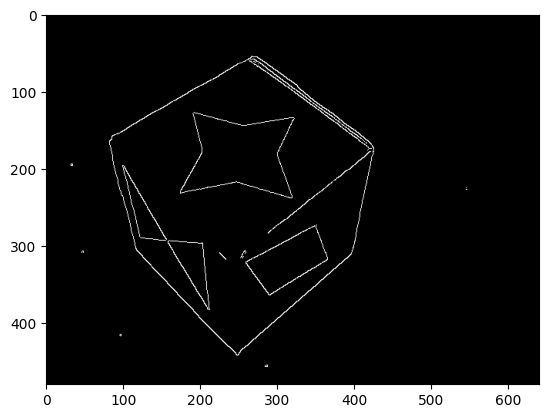

In [2]:
# Ex 7.1
# Detect edges using Canny
im = "media/week06_data/Box3.bmp"
im = cv2.imread(im, cv2.IMREAD_GRAYSCALE)

edges = cv2.Canny(im, 100, 200)
plt.imshow(edges, cmap="gray")

## Hough Transform

In [3]:
# Ex 7.2
# Compute Hough space
hspace, angles, dists = skimage.transform.hough_line(edges)
# hspace: Hough transform accumulator
# angles: Angles at which the transform is computed, in radians (theta)
# dists: Distance values at which the transform is computed (r)
print(f"angles: {len(angles)}")
print(f"dists: {len(dists)}")

angles: 180
dists: 1601


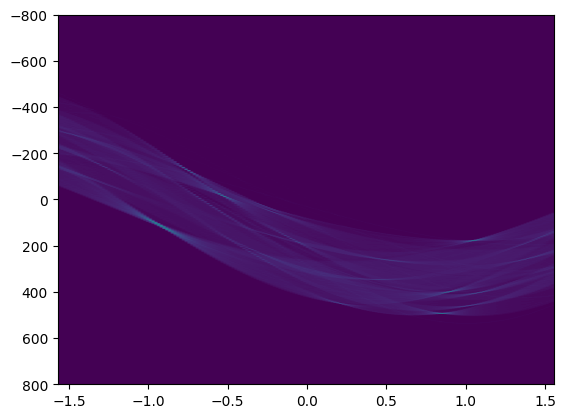

In [4]:
# Ex 7.3
# Visualize Hough space
extent = [angles[0], angles[-1], dists[-1], dists[0]]
plt.imshow(hspace, extent=extent, aspect="auto")

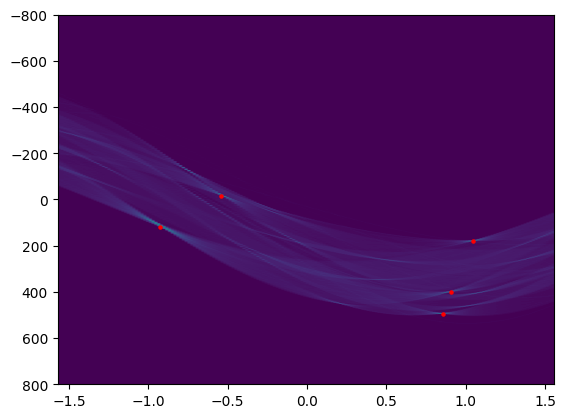

In [5]:
# Ex 7.4
# Find peaks in Hough space
from skimage.transform import hough_line_peaks

n = 5
extH, extAngles, extDists = hough_line_peaks(hspace, angles, dists, num_peaks=n)
# extH: Hough transform accumulator values at the peaks
# extAngles: Angles at which the peaks are found, in radians
# extDists: Distance values at which the peaks are found

plt.scatter(extAngles, extDists, c="r", s=5)

extent = [angles[0], angles[-1], dists[-1], dists[0]]
plt.imshow(hspace, extent=extent, aspect="auto")

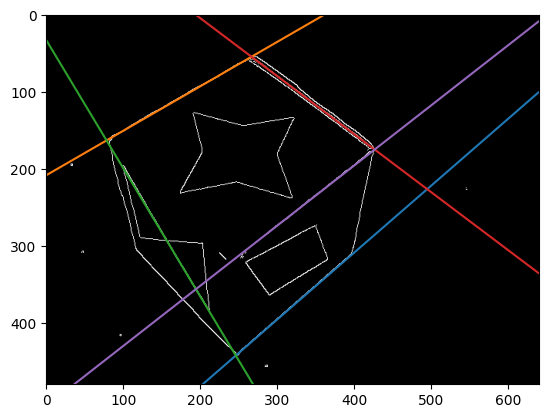

In [6]:
# Ex 7.5
# Draw lines on the original image


def DrawLine(l, shape):
    # Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame

    def in_frame(l_im):
        """Returns the intersection point of the line with the image frame."""
        q = np.cross(l.flatten(), l_im)  # intersection point
        q = q[:2] / q[2]  # convert to inhomogeneous
        if all(q >= 0) and all(q + 1 <= shape[1::-1]):
            return q

    # 4 edge lines of the image
    lines = [
        [1, 0, 0],  # x = 0
        [0, 1, 0],  # y = 0
        [1, 0, 1 - shape[1]],  # x = shape[1]
        [0, 1, 1 - shape[0]],  # y = shape[0]
    ]

    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]

    if len(P) == 0:
        print("Line is completely outside image")
    plt.plot(*np.array(P).T)


plt.imshow(edges, cmap="gray")
for i in range(n):
    angle = extAngles[i]
    dist = extDists[i]
    l = np.array([np.cos(angle), np.sin(angle), -dist])
    DrawLine(l, im.shape)

## RANSAC

In [7]:
def test_points(n_in, n_out):
    """
    Generate data set consisting of inliers with noise and outliers.

    Args:
        n_in: number of inliers
        n_out: number of outliers

    Returns:
        points: 2x(n_in+n_out) array of points
    """
    # inliers: points along y=0.5*x+b
    a = (np.random.rand(n_in) - 0.5) * 10  # [-5, 5]
    b = np.vstack((a, a * 0.5 + np.random.randn(n_in) * 0.25))  # add 0.25 noise
    # outliers: random points
    points = np.hstack((b, 2 * np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T  # randomly permute points

In [8]:
# Ex 7.6
# Function to fit a line, in homo coords, given 2 points


def fit_line(p1, p2):
    """
    Fits a line given 2 points.

    Args:
        p1, p2 (np.array) : 2x1 inhomogenous coordinates

    Returns:
        l : 3x1, line in homogenous coordinates
    """
    if p1.shape == (2,):
        p1 = p1.reshape(2, 1)
        p2 = p2.reshape(2, 1)
    if p1.shape != (2, 1) or p2.shape != (2, 1):
        raise ValueError("Points must be 2x1 np.array")

    p1h = PiInv(p1)
    p2h = PiInv(p2)
    # cross() requires input as vectors
    l = np.cross(p1h.squeeze(), p2h.squeeze())
    return l


p1 = np.array([[2, 1]]).T  # 2x1
p2 = np.array([[3, 4]]).T
l = fit_line(p1, p2)
print(f"eqn of line: {l}")

eqn of line: [-3.  1.  5.]


In [47]:
# Ex 7.7
# Function to determine inliners and outliers


def find_inliners_outliers(l, points, tau):
    """
    Args:
        l : equation of line in homogenous coordinates
        tau : threshold for inliners

    Returns:
        inliners (np.array) : 2xa, set of inliner points
        outliers (np.array) : 2xb, set of outlier points
    """
    inliners = []
    outliers = []
    for p in points.T:
        p = p.reshape(2, 1)
        ph = PiInv(p)
        d = abs(l.T @ ph) / (abs(ph[2]) * np.sqrt(l[0] ** 2 + l[1] ** 2))
        if d <= tau:  # inliner
            inliners.append(p)
        else:  # outlier
            outliers.append(p)
    inliners = np.array(inliners).squeeze().T
    outliers = np.array(outliers).squeeze().T
    return inliners, outliers


points = test_points(10, 10)
l = fit_line(points[:, 0], points[:, 1])
tau = 0.2
inliners, outliers = find_inliners_outliers(l, points, tau)

print(f"inliners.shape: {inliners.shape}, outliers.shape: {outliers.shape}")

inliners.shape: (2, 2), outliers.shape: (2, 18)


In [10]:
# Ex 7.8
# Function to calculate consensus


def consensus(l, points, tau) -> int:
    """
    Returns the number of inliners.

    Args:
        l : equation of line in homogenous coordinates
        points : 2xn, set of points
        tau : threshold for inliners

    Returns:
        consensus : number of inliners
    """
    consensus = 0
    inliners, _ = find_inliners_outliers(l, points, tau)
    consensus = inliners.shape[1]
    return consensus


n_inliners = consensus(l, points, tau)
print(f"no. of inliners: {n_inliners}")

no. of inliners: 3


In [51]:
# Ex 7.9
# Function to randomly sample two of n 2D points without replacement


def sample_points(points):
    """
    Args:
        points : nx2, set of points
        n : number of points to sample

    Returns:
        sample : 2xn, set of sampled points
    """
    n_points = 2
    sample = np.random.permutation(points.T).T[:, :n_points]
    return sample


sample = sample_points(points)
print(f"sampled points: \n{sample}")

sampled points: 
[[ 4.25591168 -4.62481341]
 [ 2.16409575 -2.45934556]]


sample: 
[[-0.85053928  4.73582989]
 [ 0.15080883  2.00376737]]
l: [-1.85295854  5.58636918 -2.41848781]


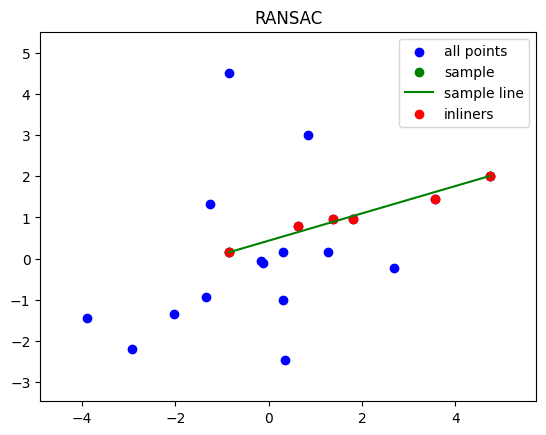

In [58]:
"""
Sample iteration of RANSAC.
"""
points = test_points(10, 10)
sample = sample_points(points)
print(f"sample: \n{sample}")
l = fit_line(sample[:, 0], sample[:, 1])
print(f"l: {l}")

tau = 0.2
inliners = []
outliers = []
for p in points.T:
    p = p.reshape(2, 1)
    ph = PiInv(p)
    d = abs(l.T @ ph) / (
        abs(ph[2]) * np.sqrt(l[0] ** 2 + l[1] ** 2)
    )  # distance from point to line
    # print(d)
    if d <= tau:  # inliner
        inliners.append(p)
    else:  # outlier
        outliers.append(p)

inliners = np.array(inliners).squeeze().T

plt.scatter(points[0], points[1], c="b", label="all points")
plt.scatter(sample[0], sample[1], c="g", label="sample")
plt.plot(sample[0], sample[1], c="g", label="sample line")
plt.scatter(inliners[0], inliners[1], c="r", label="inliners")

plt.xlim(min(points[0]) - 1, max(points[0]) + 1)
plt.ylim(min(points[1]) - 1, max(points[1]) + 1)
plt.legend()
plt.title("RANSAC")
plt.show()

In [56]:
def visualize_ransac(points, best_inliners, best_l) -> None:
    """
    Args:
        points : nx2, set of points
        best_inliners : ax2, set of inliner points
        best_l : equation of line in homogenous coordinates
    """

    plt.scatter(points[0], points[1], c="b", label="all points")
    plt.scatter(best_inliners[0], best_inliners[1], c="r", label="inliners")

    # Draw line created by samples
    slope = -best_l[0] / best_l[1]
    intercept = -best_l[2] / best_l[1]
    x = np.linspace(min(points[0]), max(points[0]), 100)
    y = slope * x + intercept
    plt.plot(x, y, c="g", label="best line")

    plt.xlim(min(points[0]) - 1, max(points[0]) + 1)
    plt.ylim(min(points[1]) - 1, max(points[1]) + 1)

    plt.legend()
    plt.title("RANSAC")
    plt.show()

best_l: [ 1.08800995 -1.6305574  -0.07850492]
no. of best_inliners: 8


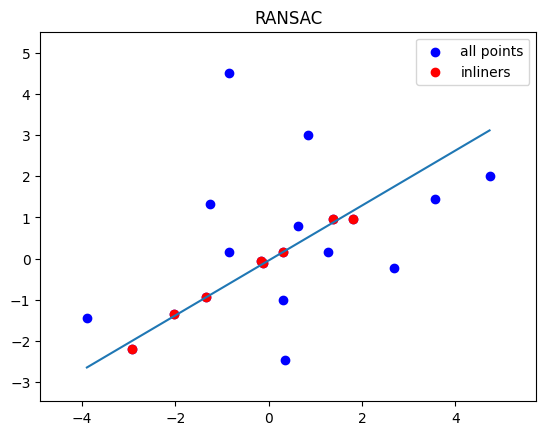

In [60]:
# Ex 7.10
# Assemble the functions to implement RANSAC


def ransac(points, iters, tau, t=5):
    """
    Args:
        points : nx2, set of points
        iters : number of iterations
        tau : threshold for inliners
        t : number of inliners to accept the model

    Returns:
        best_l : equation of line in homogenous coordinates
        best_inliners : ax2, set of inliner points
    """
    best_l = None
    best_inliners = None
    best_consensus = 0
    for _ in range(iters):
        sample = sample_points(points)
        l = fit_line(sample[:, 0], sample[:, 1])
        consensus_ = consensus(l, points, tau)
        if consensus_ > t and consensus_ > best_consensus:
            best_l = l
            best_inliners, _ = find_inliners_outliers(l, points, tau)
            best_consensus = consensus_
    return best_l, best_inliners


# points = test_points(10, 10)
max_iter = 100
tau = 0.2
best_l, best_inliners = ransac(points, max_iter, tau)

print(f"best_l: {best_l}")
print(f"no. of best_inliners: {best_inliners.shape[1]}")
visualize_ransac(points, best_inliners, best_l)

tau: 0.1, no. of best_inliners: 6


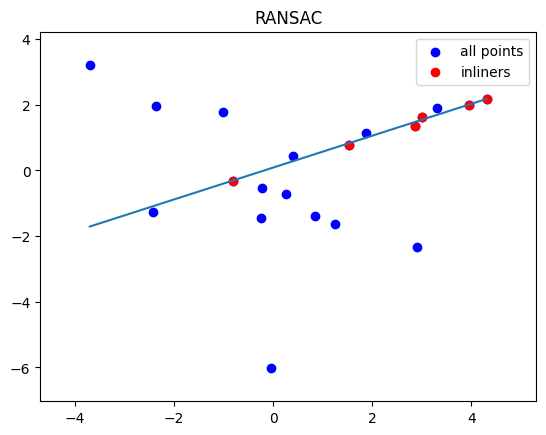

tau: 0.3, no. of best_inliners: 10


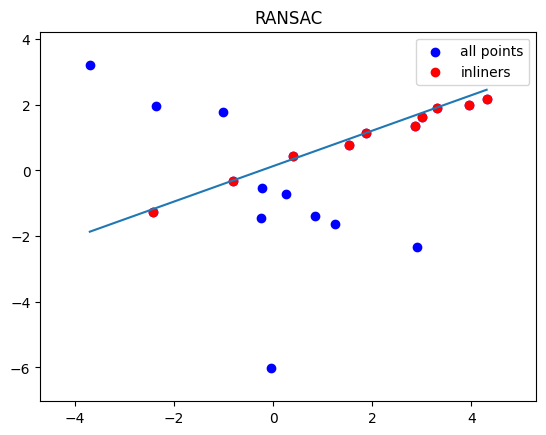

tau: 0.5, no. of best_inliners: 11


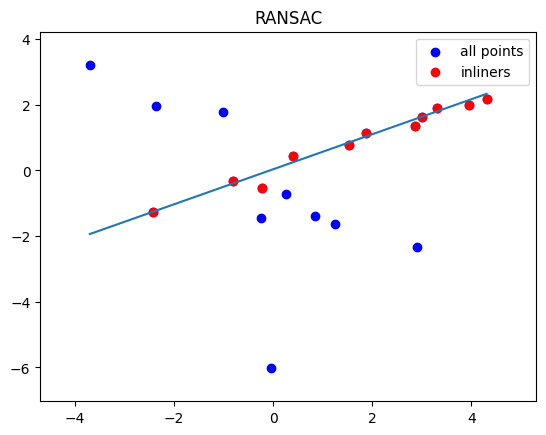

tau: 0.7, no. of best_inliners: 12


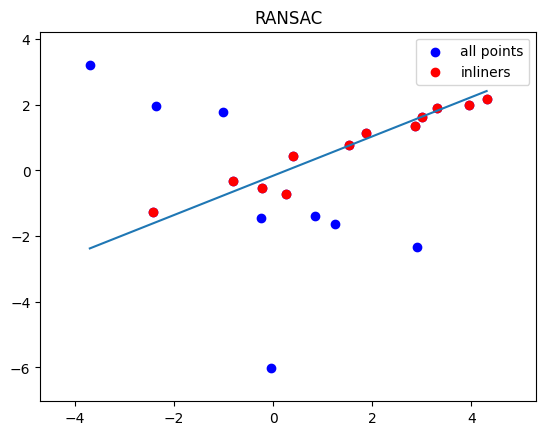

tau: 0.9, no. of best_inliners: 13


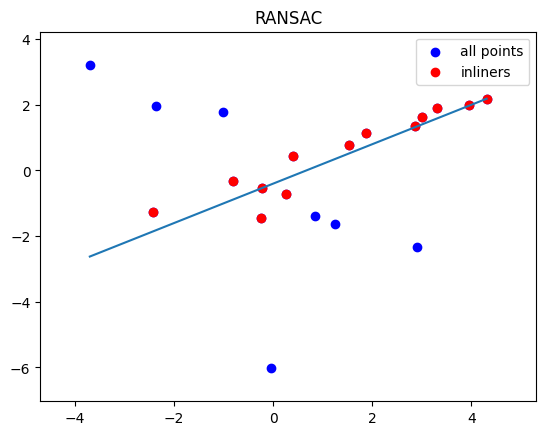

In [70]:
# Ex 7.11
# Experiment with different thresholds

points = test_points(10, 10)
tau_list = [0.1, 0.3, 0.5, 0.7, 0.9]
for tau in tau_list:
    best_l, best_inliners = ransac(points, max_iter, tau)
    print(f"tau: {tau}, no. of best_inliners: {best_inliners.shape[1]}")
    visualize_ransac(points, best_inliners, best_l)

# tau = 0.3 detected all the inliers.
# this is expected because the dataset noise was set to 0.25
# beyond 0.3, the outliers will start to be included

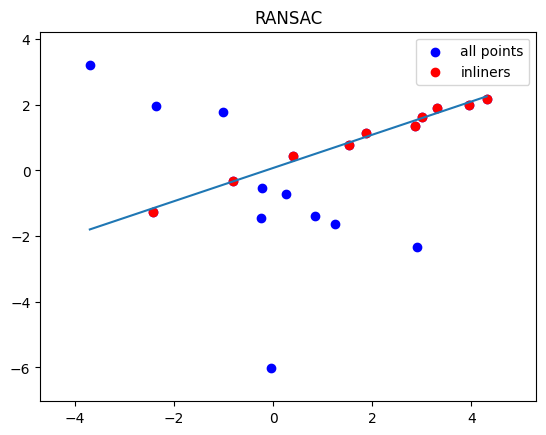

In [71]:
# Ex 7.12
# Fit new line to all inliners of the best line


def pca_line(x):  # assumes x is a (2 x n) array of points
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l @ x.mean(1)))
    return l


def ransac(points, iters, tau, t=5):
    """
    Args:
        points : nx2, set of points
        iters : number of iterations
        tau : threshold for inliners
        t : number of inliners to accept the model

    Returns:
        best_line : equation of line in homogenous coordinates
        best_inliners : ax2, set of inliner points
    """
    best_inliners = None
    best_consensus = 0
    for _ in range(iters):
        sample = sample_points(points)
        l = fit_line(sample[:, 0], sample[:, 1])
        consensus_ = consensus(l, points, tau)
        if consensus_ > t and consensus_ > best_consensus:
            best_inliners, _ = find_inliners_outliers(l, points, tau)
            best_consensus = consensus_
    # Fit new line
    best_line = pca_line(best_inliners)
    return best_line, best_inliners


# points = test_points(10, 10)
max_iter = 100
tau = 0.2
best_l, best_inliners = ransac(points, max_iter, tau)
visualize_ransac(points, best_inliners, best_l)

Stopping early at iteration 49
no. of best_inliners: 6


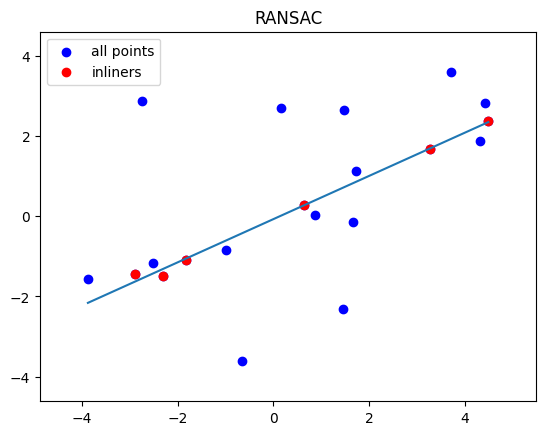

In [79]:
# Ex 7.13
# Stopping criteria


def ransac(points, iters, tau):
    """
    Args:
        points : nx2, set of points
        iters : number of iterations
        tau : threshold for inliners

    Returns:
        best_line : equation of line in homogenous coordinates
        best_inliners : ax2, set of inliner points
    """
    p = 0.99  # probability of at least one sample is free from outliers
    best_inliners = None
    best_consensus = 0
    for i in range(iters):
        sample = sample_points(points)
        l = fit_line(sample[:, 0], sample[:, 1])
        consensus_ = consensus(l, points, tau)
        if consensus_ > best_consensus:
            best_inliners, _ = find_inliners_outliers(l, points, tau)
            best_consensus = consensus_
        # Stopping criteria
        e_est = 1 - best_consensus / points.shape[1]
        N_est = np.log(1 - p) / np.log(1 - (1 - e_est) ** 2)
        if i > N_est:
            print(f"Stopping early at iteration {i}")
            break
    # Fit new line
    best_line = pca_line(best_inliners)
    return best_line, best_inliners


points = test_points(10, 10)
max_iter = 100
tau = 0.2
best_l, best_inliners = ransac(points, max_iter, tau)
print(f"no. of best_inliners: {best_inliners.shape[1]}")
visualize_ransac(points, best_inliners, best_l)